In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

Get the dataset. The class column is the label and other columns are the features. Our label is binary ("g" or "h") for gamma or hadron particle, so instead we convert it into 0,1 for easy interpretation. 1 is gamma, 0 is hadron


In [86]:
df = pd.read_csv("magic.csv", index_col=False)
columns = df.columns
df["class"] = (df["class"] == "g").astype(int)
df = df.drop_duplicates()
columns

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fAlpha', 'fDist', 'class'],
      dtype='object')

Plot all features for visualization


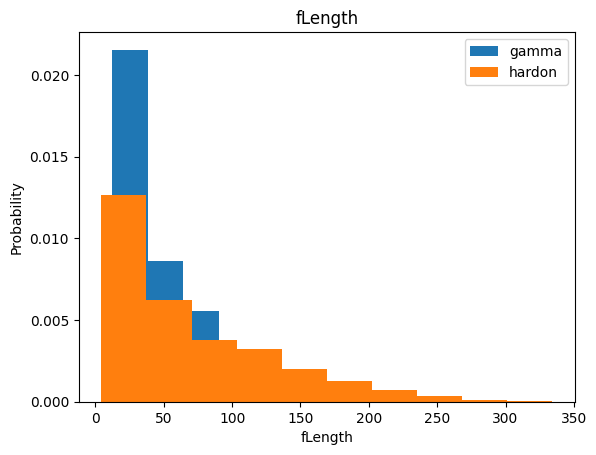

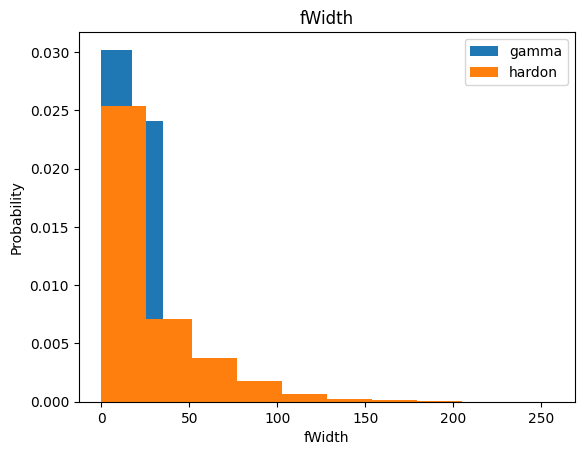

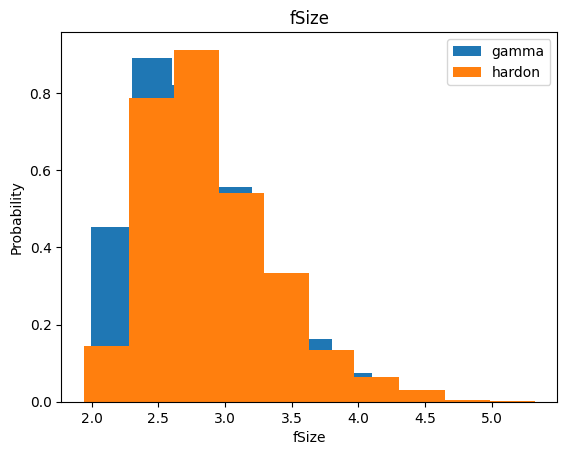

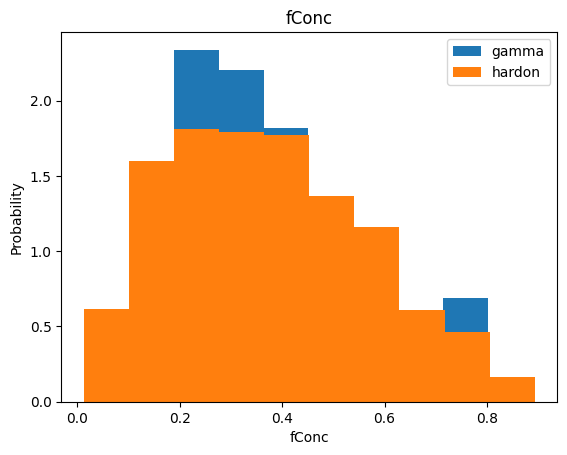

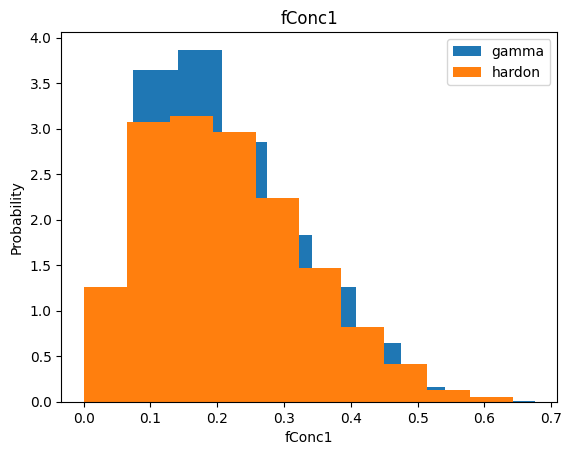

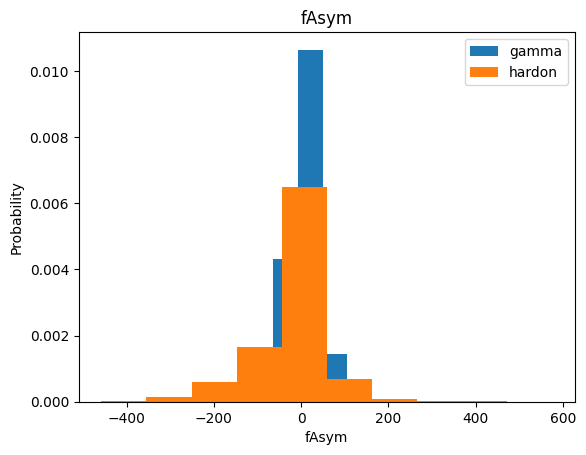

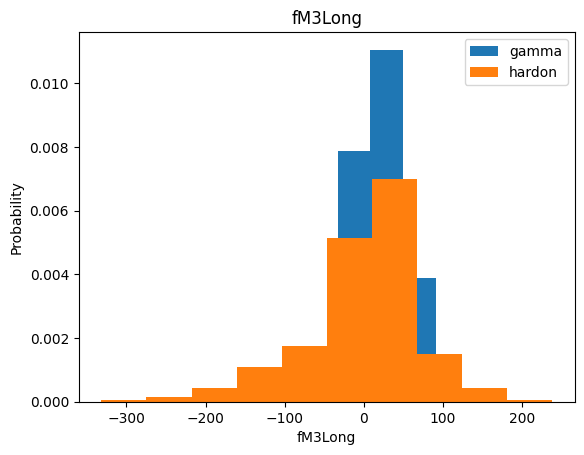

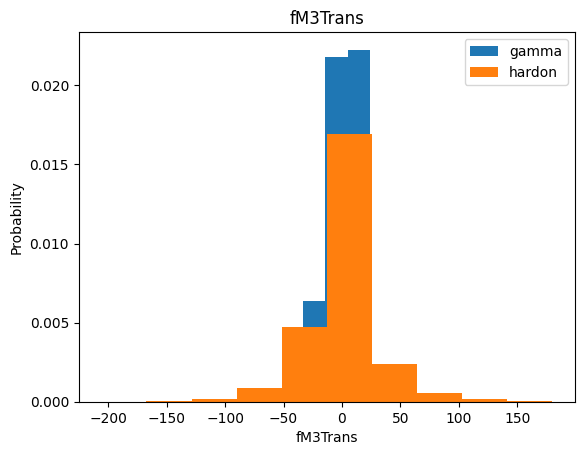

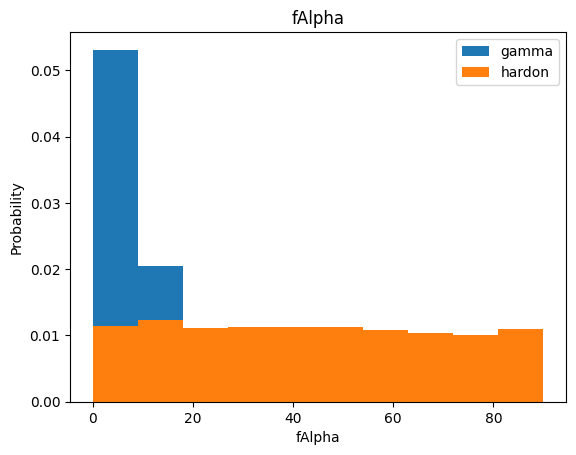

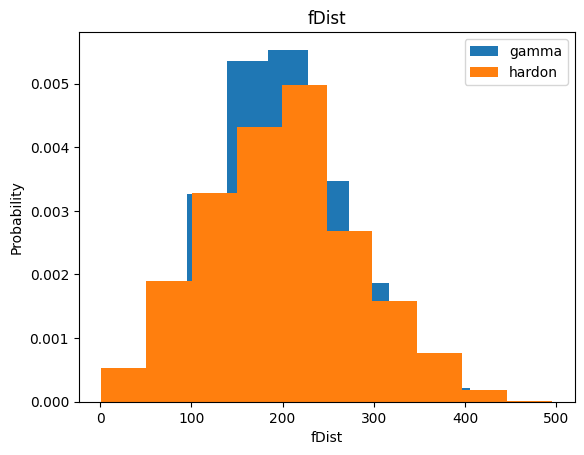

In [87]:
for feature in columns[:-1]:
    plt.hist(df[df["class"] == 1][feature], label="gamma", density=True)
    plt.hist(df[df["class"] == 0][feature], label="hardon", density=True)
    plt.title(feature)
    plt.ylabel("Probability")
    plt.xlabel(feature)
    plt.legend()
    plt.show()

Create training, validation and test data.

- `train_df` - used for training the model
- `valid_df` - used to get metrics for our model during training. Based on the validation dataset, we change our hyper-parameters like no. of neighbors in kNN
- `test_df` - used to test the effectiveness of our fully trained model.

`df.sample(frac=1)` is used to get random samples from our dataset. Setting frac=1 lets us shuffle the entire df


In [88]:
train_df, valid_df, test_df = np.split(
    df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))]
)
train_df.shape, valid_df.shape, test_df.shape

/Users/tusharlock10/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


((11343, 11), (3781, 11), (3781, 11))

### Issues -

- We have different magnitude of values in different columns. We need to standardize these values so that we can compare features with each other
- We have data which has more gamma values compared to hadron. We need to over-sample our training dataset to get equal no. of gamma and hadron data, so that there are no biases towards gamma class in our model.

### What is over-sampling -

A technique to incorporate more of the minority data into our training dataset by duplicating it, so that our model can train on equal no. of data of each label


In [89]:
def scale_dataset(df, over_sample=False):
    X = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values

    # scale the features to standard deviation
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if over_sample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    #
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [90]:
train, x_train, y_train = scale_dataset(train_df, over_sample=True)
valid, x_valid, y_valid = scale_dataset(valid_df)
test, x_test, y_test = scale_dataset(test_df)

### kNN - k Nearest Neighbors
Using this algorithm, we can predict the label for the test data, by looking at its k nearest neighbors in multi-dimensional space (1-D, 2-D, 3-D, 4-D, etc. ). Nearest neighbors are classified as known data points which are closest in distance to the test data point.

k is the hyperparameter that needs to be tweaked to get the best possible loss for our model

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [92]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [93]:
y_predict = knn_model.predict(x_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1333
           1       0.87      0.80      0.84      2448

    accuracy                           0.80      3781
   macro avg       0.78      0.80      0.79      3781
weighted avg       0.81      0.80      0.80      3781



### Naive Base
Based on probabilities. Given the probability of A happened, what is the probability of B happening. This is used with features to get the probability of a classification

In [94]:
from sklearn.naive_bayes import GaussianNB

In [95]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

In [96]:
y_predict = nb_model.predict(x_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      1333
           1       0.73      0.89      0.80      2448

    accuracy                           0.72      3781
   macro avg       0.70      0.64      0.65      3781
weighted avg       0.71      0.72      0.70      3781

